# Домашнее задание
## Тема: «Синтаксический анализ и выделение ключевых слов»

In [1]:
import json
import bz2
import regex
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()
from scipy import sparse
import codecs
import random

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [4]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:40, 4982.80it/s]


In [5]:
responses[404]

{'city': 'г. Москва',
 'rating_not_checked': False,
 'title': 'Ужасное обслуживание',
 'num_comments': 1,
 'bank_license': 'лицензия № 429',
 'author': 'svt2014',
 'bank_name': 'Уральский Банк Реконструкции и Развития',
 'datetime': '2015-05-29 23:15:56',
 'text': 'Сегодня закрывала вклад в Московском отделении Уральского Банка Реконструкции и Развития. Отделение работает с 9.00. Пришла к 10, работает с физическими лицами один менеджер. Очередь человек на 30. В зале все стулья заняты, часть народа гуляет. В 10.45 появилась еще одна девушка и юноша. Занимаются своими делами, очередь на них смотрит. Возмутилась, юноша сообщил, что рабочий день у них с 11, поэтому в свое личное время они могут заниматься своими делами. Прошло еще 45 минут, юноша-начальник смотрит в планшет, обсуждает личные дела с другими знакомыми юношами, никого из очереди не берет. Взорвалась! Выяснилось, что юноша - начальник оказывается может\xa0обслуживать вкладчиков. Через 1 час 45 минут забрала вклад. Больше в это

## Часть 1. Анализ текстов [40/100]

In [6]:
df = pd.DataFrame(responses)
df.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


Наблюдения без рейтинга удаляем

In [8]:
df.dropna(subset=['rating_grade'], inplace = True)
df.shape

(88658, 10)

**1. Посчитайте количество отзывов в разных городах и на разные банки**

In [9]:
cities=df.groupby(['city']).count()['text'].sort_values( ascending=False).head(29)
banks=df.groupby(['bank_name']).count()['text'].sort_values( ascending=False).head(29)

По банкам

Text(0.5, 0, 'Количество отзывов по банкам')

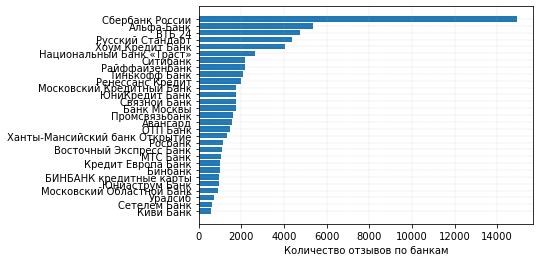

In [10]:
plt.barh(banks.index[::-1],banks.values[::-1])
plt.grid( linestyle='-.', linewidth=0.2)
plt.xlabel('Количество отзывов по банкам')

По городам

Text(0.5, 0, 'Количество отзывов по городам')

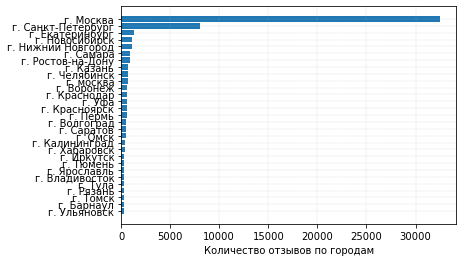

In [11]:
plt.barh(cities.index[::-1],cities.values[::-1])
plt.grid( linestyle='-.', linewidth=0.2)
plt.xlabel('Количество отзывов по городам')

**2. Постройте гистограмы длин слов в символах и в словах**

В символах

In [12]:
df['text_len'] = df['text'].progress_apply(len)
df.sort_values(by="text_len", ascending=False)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,text_len
49155,г. Сафоново,False,Хамство и унижение посетителей,5,лицензия № 1481,Ден22ден,Сбербанк России,2014-04-27 18:37:00,"Доброго времени суток. Я, Ливанцов Денис Анато...",1.0,32082
118257,г. Москва,False,Личный (и печальный) опыт попытки оспорить мош...,26,лицензия № 3292,cybernatic-cat,Райффайзенбанк,2011-10-18 21:57:00,Весь пост (крайне объёмный) опубликован мной в...,2.0,29679
26023,г. Москва,False,,12,лицензия № 2748,ileon,Банк Москвы,2014-11-22 20:04:00,Как и обещал в своем предыдущем отзыве от 29 о...,1.0,27364
38104,г. Москва,False,,5,лицензия № 1481,Knever,Сбербанк России,2014-08-08 15:04:00,Введение оно же вывод. Данный отзыв содержит к...,1.0,27220
86611,г. Москва,False,"Больше нет причин, которые бы меня держали в э...",14,лицензия № 1326,iSavaDev,Альфа-Банк,2013-04-06 21:49:00,История за 10 лет... Напишу кратко (это действ...,1.0,24604
...,...,...,...,...,...,...,...,...,...,...,...
148794,None,False,Не отвечают по своим обязательствам,3,лицензия № 3392 (отозвана),Kosta-1,Городской Клиентский,2006-12-18 22:34:00,"Не проводят платежи уже 3 недели. Говорят, нет...",1.0,53
152261,None,False,Хороший банк,0,лицензия № 2291,Sergey,ИМПЭКСБанк,2005-09-23 19:05:00,Быстро получил 150.000 без каких-либо проблем.,5.0,46
151714,None,False,Отказ от валютообменных операций,0,лицензия № 2575 (отозвана),Василий,Форпост,2005-11-30 14:38:00,Банк больше не работает с обменниками..,3.0,39
152684,None,False,Долго делают карту,0,лицензия № 2562,клиент,Бинбанк,2005-06-29 16:39:00,Делают карту VISA почти 3 недели...,1.0,35


<AxesSubplot:>

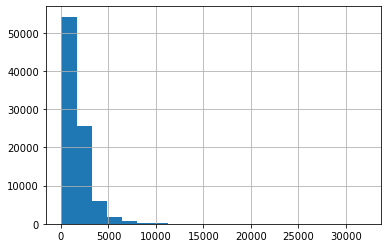

In [13]:
df['text_len'].hist(bins=20)

In [14]:
df['text_len'].describe()

count    88658.000000
mean      1718.655711
std       1387.903005
min         31.000000
25%        852.000000
50%       1345.000000
75%       2131.000000
max      32082.000000
Name: text_len, dtype: float64

В словах

In [15]:
import re
regex = re.compile("[а-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [16]:
df['text_words'] = df['text'].str.lower().progress_apply(words_only)
df.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,text_len,text_words
14,г. Москва,False,В Шоке,0,лицензия № 2673,yura1189,Тинькофф Банк,2015-06-05 13:52:40,"Также как и многие давний клиент банка, был до...",2.0,1649,также как и многие давний клиент банка был дов...
19,г. Москва,False,Некомпетентность сотрудников банка,2,лицензия № 1481,agelun,Сбербанк России,2015-06-05 15:00:54,Открыт вклад и счет в USD. Плюс к этому есть з...,1.0,2214,открыт вклад и счет в плюс к этому есть зарпла...
33,г. Ростов-на-Дону,False,Навязывание страховки,1,лицензия № 1481,Joker888,Сбербанк России,2015-06-05 21:35:40,Доброго времени! Вчера мне поступило смс-уведо...,1.0,2159,доброго времени вчера мне поступило смс уведом...


In [17]:
df['words_count'] = df['text_words'].progress_apply(lambda x: len(x.split()))
df.sort_values(by="words_count", ascending=False)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,text_len,text_words,words_count
49155,г. Сафоново,False,Хамство и унижение посетителей,5,лицензия № 1481,Ден22ден,Сбербанк России,2014-04-27 18:37:00,"Доброго времени суток. Я, Ливанцов Денис Анато...",1.0,32082,доброго времени суток я ливанцов денис анатоль...,5001
118257,г. Москва,False,Личный (и печальный) опыт попытки оспорить мош...,26,лицензия № 3292,cybernatic-cat,Райффайзенбанк,2011-10-18 21:57:00,Весь пост (крайне объёмный) опубликован мной в...,2.0,29679,весь пост крайне объ мный опубликован мной в ж...,4099
38104,г. Москва,False,,5,лицензия № 1481,Knever,Сбербанк России,2014-08-08 15:04:00,Введение оно же вывод. Данный отзыв содержит к...,1.0,27220,введение оно же вывод данный отзыв содержит кр...,4021
86611,г. Москва,False,"Больше нет причин, которые бы меня держали в э...",14,лицензия № 1326,iSavaDev,Альфа-Банк,2013-04-06 21:49:00,История за 10 лет... Напишу кратко (это действ...,1.0,24604,история за лет напишу кратко это действительно...,3939
26023,г. Москва,False,,12,лицензия № 2748,ileon,Банк Москвы,2014-11-22 20:04:00,Как и обещал в своем предыдущем отзыве от 29 о...,1.0,27364,как и обещал в своем предыдущем отзыве от октя...,3557
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152261,None,False,Хороший банк,0,лицензия № 2291,Sergey,ИМПЭКСБанк,2005-09-23 19:05:00,Быстро получил 150.000 без каких-либо проблем.,5.0,46,быстро получил без каких либо проблем,6
151714,None,False,Отказ от валютообменных операций,0,лицензия № 2575 (отозвана),Василий,Форпост,2005-11-30 14:38:00,Банк больше не работает с обменниками..,3.0,39,банк больше не работает с обменниками,6
153286,None,False,Охранники,0,лицензия № 828 (аннулирована),угу,Ярсоцбанк,2005-04-28 15:01:00,Охранники у банка слишком злые.,3.0,31,охранники у банка слишком злые,5
152684,None,False,Долго делают карту,0,лицензия № 2562,клиент,Бинбанк,2005-06-29 16:39:00,Делают карту VISA почти 3 недели...,1.0,35,делают карту почти недели,4


Проверяем на транслитеррацию

<AxesSubplot:>

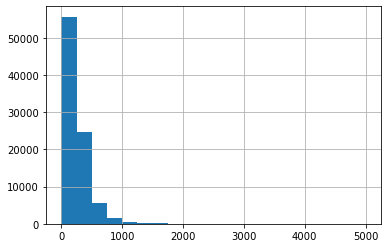

In [18]:
df['words_count'].hist(bins=20)

In [20]:
df['words_count'].describe()

count    88658.000000
mean       255.816339
std        208.277098
min          0.000000
25%        125.000000
50%        200.000000
75%        318.000000
max       5001.000000
Name: words_count, dtype: float64

In [3]:
from time import sleep
from tqdm import tqdm

**3. Найдите 10 самых частых:**
*   слов
*   слов без стоп-слов
*   лемм
*   существительных

Слова

In [23]:
from collections import Counter
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['text_words'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))
for i in cnt.most_common(10):
    print(i)

100%|██████████| 88658/88658 [11:58<00:00, 123.43it/s]

('в', 859205)
('и', 683760)
('не', 541870)
('на', 453390)
('что', 417356)
('я', 368386)
('с', 288214)
('по', 232882)
('мне', 209093)
('банка', 171118)


Кривая Ципфа

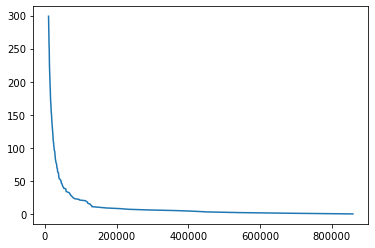

In [24]:
freqs = list(cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

Кривая Хипса

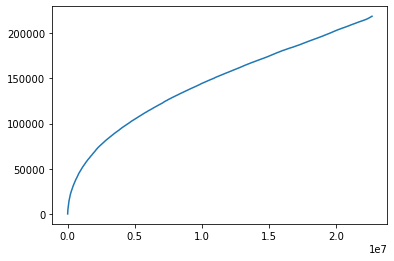

In [25]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_types)
plt.show()

Стоп-слова

In [26]:
from nltk.corpus import stopwords
nltk.download('stopwords')
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/filipprodcenkov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
df['text_words_stop'] = df['text_words'].progress_apply(remove_stopwords)

In [28]:
cnt_stop = Counter()
n_types_stop = []
n_tokens_stop = []
tokens_stop = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens_stop = row['text_words_stop'].split()
    cnt_stop.update(tokens_stop)
    n_types_stop.append(len(cnt_stop))
    n_tokens_stop.append(sum(list(cnt_stop.values())))
for i in cnt_stop.most_common(10):
    print(i)

100%|██████████| 88658/88658 [11:56<00:00, 123.74it/s]

('банка', 171118)
('банк', 130753)
('деньги', 83171)
('карту', 69033)
('карты', 63121)
('отделение', 48431)
('день', 48092)
('кредит', 47746)
('банке', 46245)
('заявление', 45279)


Кривая Ципфа

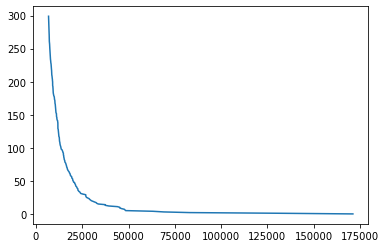

In [29]:
freqs = list(cnt_stop.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

Кривая Хипса

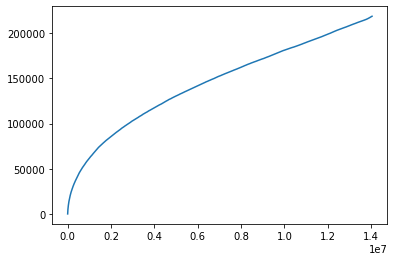

In [30]:
fig, ax = plt.subplots()
ax.plot(n_tokens_stop, n_types_stop)
plt.show()

Леммы

In [31]:
from pymorphy2 import MorphAnalyzer
pm2 = MorphAnalyzer()

from nltk.tokenize import toktok
toktok = toktok.ToktokTokenizer()


def lemmatize(text, morph=pm2):
    try:
        return ' '.join([morph.parse(word)[0].normal_form for word in text.split()])
    except:
        return " "

def mystem_analysis(text):
    try:
        in_file = uuid.uuid4().hex
        out_file = uuid.uuid4().hex
        with codecs.open(in_file, 'w', encoding='utf8') as f:
            f.write(text)

        !mystem -i --format json {in_file} {out_file}

        with codecs.open(out_file, 'r', encoding='utf8') as f:
            out = f.read()
            
        os.remove(in_file)
        os.remove(out_file)
        return out
    except:
        return " "

def pymorph_analysis(text):
    try:
        return [pm2.parse(word) for word in toktok.tokenize(text)]
    except:
        return []

In [32]:
mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь']
def remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return " "

In [33]:
def get_lemmas(arr):
    return ' '.join([lemma[0].normal_form for lemma in arr if not lemma[0].normal_form in mystoplemmas])

In [34]:
df['text_analysis'] = df['text_words_stop'].progress_apply(pymorph_analysis)

In [35]:
df['lemma'] = df['text_analysis'].progress_apply(get_lemmas)
df.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,text_len,text_words,words_count,text_words_stop,text_analysis,lemma
14,г. Москва,False,В Шоке,0,лицензия № 2673,yura1189,Тинькофф Банк,2015-06-05 13:52:40,"Также как и многие давний клиент банка, был до...",2.0,1649,также как и многие давний клиент банка был дов...,237,многие давний клиент банка доволен высшей степ...,"[[(многие, NPRO plur,nomn, многие, 0.679245, (...",многие давний клиент банк довольный высокий ст...
19,г. Москва,False,Некомпетентность сотрудников банка,2,лицензия № 1481,agelun,Сбербанк России,2015-06-05 15:00:54,Открыт вклад и счет в USD. Плюс к этому есть з...,1.0,2214,открыт вклад и счет в плюс к этому есть зарпла...,342,открыт вклад счет плюс этому зарплатная карта ...,"[[(открыт, PRTS,perf,past,pssv masc,sing, откр...",открыть вклад счёт плюс этот зарплатный карта ...
33,г. Ростов-на-Дону,False,Навязывание страховки,1,лицензия № 1481,Joker888,Сбербанк России,2015-06-05 21:35:40,Доброго времени! Вчера мне поступило смс-уведо...,1.0,2159,доброго времени вчера мне поступило смс уведом...,311,доброго времени вчера поступило смс уведомлени...,"[[(доброго, ADJF,Qual neut,sing,gent, добрый, ...",добрый время вчера поступить смс уведомление б...


In [36]:
cnt_lemmas = Counter()
n_types_lemmas = []
n_tokens_lemmas = []
tokens_lemmas = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens_lemmas = row['lemma'].split()
    cnt_lemmas.update(tokens_lemmas)
    n_types_lemmas.append(len(cnt_lemmas))
    n_tokens_lemmas.append(sum(list(cnt_lemmas.values())))
for i in cnt_lemmas.most_common(10):
    print(i)

100%|██████████| 88658/88658 [04:15<00:00, 346.84it/s]

('банк', 413149)
('карта', 211438)
('деньга', 114398)
('день', 112825)
('отделение', 105610)
('мой', 98205)
('кредит', 91324)
('сотрудник', 88252)
('клиент', 88018)
('счёт', 81909)


Кривая Ципфа

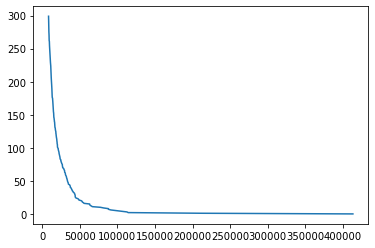

In [37]:
freqs = list(cnt_lemmas.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

Кривая Хипса

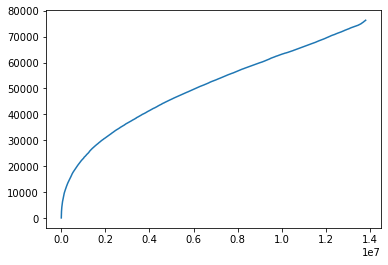

In [38]:
fig, ax = plt.subplots()
ax.plot(n_tokens_lemmas, n_types_lemmas)
plt.show()

Существительные

In [39]:
cnt_noun = Counter()
n_types_noun = []
n_tokens_noun = []
tokens_noun = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens_noun = [lemma[0].normal_form for lemma in row['text_analysis'] if 'NOUN' in lemma[0].tag]
    cnt_noun.update(tokens_noun)
    n_types_noun.append(len(cnt_noun))
    n_tokens_noun.append(sum(list(cnt_noun.values())))
for i in cnt_noun.most_common(10):
    print(i)

100%|██████████| 88658/88658 [02:26<00:00, 606.95it/s] 


('банк', 413149)
('карта', 211438)
('деньга', 114398)
('день', 112825)
('отделение', 105610)
('кредит', 91324)
('сотрудник', 88252)
('клиент', 88018)
('счёт', 81909)
('заявление', 66721)


Кривая Ципфа

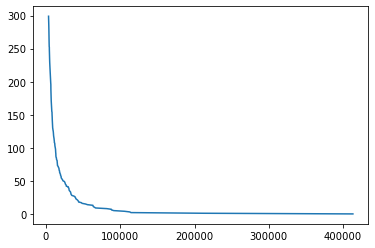

In [40]:
freqs = list(cnt_noun.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

Кривая Хипса

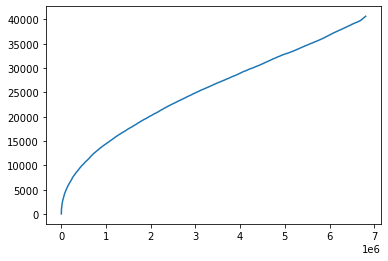

In [41]:
fig, ax = plt.subplots()
ax.plot(n_tokens_noun, n_types_noun)
plt.show()

**4. Ответьте на следующие вопросы:**  
какое слово встречается чаще, "сотрудник" или "клиент"?  
сколько раз встречается слова "мошенничество" и "доверие"?

In [42]:
print(f"слово \"сотрудник\" встречается {cnt['сотрудник']} раз")
print(f"слово \"клиент\" встречается {cnt['клиент']} раз")
if cnt['клиент'] > cnt['сотрудник']:
      print("слово \"клиент\" встречается чаще, чем слово \"сотрудник\"")
else:
      print("слово \"сотрудник\" встречается чаще, чем слово \"клиент\"")

слово "сотрудник" встречается 20958 раз
слово "клиент" встречается 12963 раз
слово "сотрудник" встречается чаще, чем слово "клиент"


In [43]:
print(f"слово \"мошенничество\" встречается {cnt['мошенничество']} раз")
print(f"слово \"доверие\" встречается {cnt['доверие']} раз")
if cnt['доверие'] > cnt['мошенничество']:
      print("слово \"доверие\" встречается чаще, чем слово \"мошенничество\"")
else:
      print("слово \"мошенничество\" встречается чаще, чем слово \"доверие\"")

слово "мошенничество" встречается 493 раз
слово "доверие" встречается 699 раз
слово "доверие" встречается чаще, чем слово "мошенничество"


**5. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)**

In [44]:
df['rating_grade'].fillna(0, inplace=True)
df['rating_grade'].unique()

array([2., 1., 5., 3., 4.])

In [45]:
tokens_by_rating = []
for rating in range(6):
    tokens = []
    sample = df[df['rating_grade']==rating]['lemma']

    for i in range(len(sample)):
        tokens += sample.iloc[i].split()
    tokens_by_rating.append(tokens)

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [47]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_rating])
feature_names = tfidf.get_feature_names() 
tfidf_ranking1_uni = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking1_uni.append(phrase)

Униграммы отрицательных отзывов

In [48]:
rankings = pd.DataFrame({'negtive_uni': tfidf_ranking1_uni})
rankings.head()

,negtive_uni
0,банк
1,карта
2,деньга
3,день
4,мой


In [49]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_rating])
feature_names = tfidf.get_feature_names() 
tfidf_ranking1_bi = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking1_bi.append(phrase)

Биграммы отрицательных отзывов

In [50]:
rankings = pd.DataFrame({'negative_bi': tfidf_ranking1_bi})
rankings.head()

,negative_bi
0,сотрудник банк
1,кредитный карта
2,отделение банк
3,денежный средство
4,написать заявление


In [51]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_rating])
feature_names = tfidf.get_feature_names() 
tfidf_ranking5_uni = []
dense = tfidf_matrix.todense()

text = dense[5].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking5_uni.append(phrase)

Униграммы положительных отзывов

In [52]:
rankings = pd.DataFrame({'positive_uni': tfidf_ranking5_uni})
rankings.head()

,positive_uni
0,банк
1,карта
2,очень
3,день
4,кредит


In [53]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_rating])
feature_names = tfidf.get_feature_names() 
tfidf_ranking5_bi = []
dense = tfidf_matrix.todense()

text = dense[5].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking5_bi.append(phrase)

Биграммы положительных отзывов

In [54]:
rankings = pd.DataFrame({'positive_bi': tfidf_ranking5_bi})
rankings.head()

,positive_bi
0,интернет банк
1,кредитный карта
2,другой банк
3,сотрудник банк
4,клиент банк


## Часть 2. Тематическое моделирование [20/100]

Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.  
Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

In [55]:
import gensim.corpora as corpora
from gensim.models import ldamodel

/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [56]:
texts = [df['lemma'].iloc[i].split() for i in range(len(df))]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [57]:
random.seed(30)

In [58]:
lda = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=20, alpha='auto', eta='auto', iterations = 20, passes = 5)

In [59]:
lda.show_topics(20)

[(0,
  '0.108*"карта" + 0.056*"кредитный" + 0.034*"лимит" + 0.027*"ситибанк" + 0.024*"счёт" + 0.022*"выписка" + 0.021*"кредитка" + 0.019*"банк" + 0.017*"сити" + 0.016*"год"'),
 (1,
  '0.104*"деньга" + 0.101*"банкомат" + 0.023*"карта" + 0.018*"счёт" + 0.017*"снять" + 0.017*"сумма" + 0.014*"день" + 0.012*"купюра" + 0.012*"операция" + 0.012*"выдать"'),
 (2,
  '0.039*"день" + 0.032*"позвонить" + 0.032*"сказать" + 0.024*"банк" + 0.022*"отделение" + 0.015*"заявка" + 0.012*"центр" + 0.011*"вопрос" + 0.011*"время" + 0.011*"девушка"'),
 (3,
  '0.028*"очередь" + 0.021*"отделение" + 0.017*"работать" + 0.017*"минута" + 0.015*"клиент" + 0.014*"касса" + 0.013*"человек" + 0.011*"время" + 0.010*"час" + 0.009*"один"'),
 (4,
  '0.085*"заявление" + 0.034*"написать" + 0.033*"банк" + 0.030*"претензия" + 0.029*"день" + 0.023*"ответ" + 0.022*"мой" + 0.021*"срок" + 0.017*"месяц" + 0.016*"рассмотрение"'),
 (5,
  '0.128*"вклад" + 0.042*"банк" + 0.041*"деньга" + 0.035*"открыть" + 0.031*"процент" + 0.030*"депозит

In [60]:
lda15 = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=15, alpha='auto', eta='auto', iterations = 20, passes = 5)

In [61]:
lda15.show_topics(15)

[(0,
  '0.089*"вклад" + 0.042*"банк" + 0.032*"счёт" + 0.032*"открыть" + 0.024*"деньга" + 0.021*"депозит" + 0.021*"процент" + 0.017*"договор" + 0.015*"открытие" + 0.014*"офис"'),
 (1,
  '0.057*"день" + 0.031*"банк" + 0.027*"позвонить" + 0.021*"неделя" + 0.021*"сказать" + 0.017*"заявка" + 0.017*"заявление" + 0.015*"ответ" + 0.015*"звонить" + 0.013*"отделение"'),
 (2,
  '0.088*"альфа" + 0.087*"услуга" + 0.069*"смс" + 0.043*"банк" + 0.032*"подключить" + 0.026*"мобильный" + 0.026*"приходить" + 0.017*"альф" + 0.017*"телефон" + 0.013*"отключить"'),
 (3,
  '0.068*"кредит" + 0.041*"банк" + 0.031*"платёж" + 0.031*"сумма" + 0.017*"задолженность" + 0.017*"кредитный" + 0.017*"месяц" + 0.015*"погашение" + 0.014*"год" + 0.013*"процент"'),
 (4,
  '0.194*"карта" + 0.024*"отделение" + 0.018*"заявление" + 0.017*"кредитный" + 0.016*"банк" + 0.013*"получить" + 0.013*"счёт" + 0.011*"карточка" + 0.011*"мой" + 0.009*"дебетовый"'),
 (5,
  '0.090*"деньга" + 0.086*"банкомат" + 0.023*"счёт" + 0.018*"карта" + 0.01

In [62]:
lda10 = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto', iterations = 20, passes = 5)

In [63]:
lda10.show_topics(10)

[(0,
  '0.080*"деньга" + 0.068*"банкомат" + 0.023*"день" + 0.018*"счёт" + 0.017*"банк" + 0.016*"карта" + 0.014*"сумма" + 0.013*"снять" + 0.012*"заявление" + 0.011*"средство"'),
 (1,
  '0.134*"карта" + 0.019*"банк" + 0.015*"заявление" + 0.014*"кредитный" + 0.014*"отделение" + 0.012*"день" + 0.011*"сказать" + 0.011*"получить" + 0.009*"позвонить" + 0.009*"карточка"'),
 (2,
  '0.077*"вклад" + 0.036*"банк" + 0.030*"счёт" + 0.030*"деньга" + 0.025*"открыть" + 0.018*"процент" + 0.018*"депозит" + 0.014*"сумма" + 0.012*"день" + 0.011*"открытие"'),
 (3,
  '0.013*"банк" + 0.010*"отделение" + 0.010*"работать" + 0.010*"человек" + 0.009*"клиент" + 0.009*"минута" + 0.009*"сказать" + 0.009*"говорить" + 0.008*"девушка" + 0.008*"очередь"'),
 (4,
  '0.033*"банк" + 0.020*"мой" + 0.016*"сотрудник" + 0.015*"ответ" + 0.014*"заявление" + 0.013*"г" + 0.012*"отделение" + 0.011*"телефон" + 0.010*"вопрос" + 0.010*"номер"'),
 (5,
  '0.050*"кредит" + 0.041*"банк" + 0.028*"платёж" + 0.026*"сумма" + 0.017*"месяц" + 0.

In [64]:
df.bank_name.value_counts(normalize=1).head()

Сбербанк России     0.168558
Альфа-Банк          0.060660
ВТБ 24              0.053870
Русский Стандарт    0.049268
Хоум Кредит Банк    0.045433
Name: bank_name, dtype: float64

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).
1.   Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
2.   Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.
3.   Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:

*   1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD)
*   2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation)

Используйте accuracy и F-measure для оценки качества классификации.  
Ниже написан примерный Pipeline для классификации текстов.  
Эта часть задания может быть сделана с использованием sklearn.

In [65]:
df_class = df.loc[df['rating_grade'].isin([1, 5])][['bank_name', 'num_comments', 'lemma', 'words_count', 'rating_grade']].reset_index(drop=True)

In [66]:
df_class['rating'] = df_class['rating_grade'].apply(lambda x: 1 if x == 5 else 0)

In [67]:
df_class.to_pickle('df_class.zip')

In [68]:
df_class = pd.read_pickle('df_class.zip')

In [69]:
df_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62100 entries, 0 to 62099
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bank_name     62100 non-null  object 
 1   num_comments  62100 non-null  int64  
 2   lemma         62100 non-null  object 
 3   words_count   62100 non-null  int64  
 4   rating_grade  62100 non-null  float64
 5   rating        62100 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 2.8+ MB


In [70]:
df_class.head()

,bank_name,num_comments,lemma,words_count,rating_grade,rating
0,Сбербанк России,2,открыть вклад счёт плюс этот зарплатный карта ...,342,1.0,0
1,Сбербанк России,1,добрый время вчера поступить смс уведомление б...,311,1.0,0
2,АктивКапитал Банк,0,г около час прийти указанный офис намерение по...,184,1.0,0
3,Сбербанк России,4,оплата коммунальный платёж пользоваться пласти...,57,1.0,0
4,Сбербанк России,16,апрель год прийти отделение сбербанк г чапаевс...,265,1.0,0


In [71]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

In [72]:
random.seed(30)

In [73]:
features = ['bank_name', 'num_comments', 'lemma', 'words_count']
target = ['rating']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(df_class[features], df_class[target], test_size=0.2)

In [75]:
X_train.head()

,bank_name,num_comments,lemma,words_count
22290,Хоум Кредит Банк,5,хоум кредит банк являться клиент ваш банк прек...,94
10361,Интеркоммерц Банк,0,держать банк карта причём выдать бесплатно гол...,169
18790,Лето Банк,3,подходящий слово запас охарактеризовать летоба...,431
8088,ОТП Банк,1,работать неквалифицированный безграмотный невн...,476
49535,Современный Коммерческий Банк (бывш. ДжиИ Мани...,14,итак история март прошлое год появиться кредит...,352


In [76]:
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        return X[self.key]

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [77]:
text1 = Pipeline([
    ('selector', TextSelector(key='lemma')),
    ('cnt_vect', CountVectorizer()),
    ('tfidf_tr', TfidfTransformer()),
    ('lsa', TruncatedSVD(n_components=100))
])
text1.fit_transform(X_train)

array([[ 0.14264276, -0.04026371, -0.07350636, ...,  0.01918202,
         0.00321202, -0.02934896],
       [ 0.24745528,  0.00765214,  0.18957516, ...,  0.01140881,
         0.0180344 , -0.01352379],
       [ 0.243568  , -0.1125002 , -0.0993269 , ...,  0.01247025,
         0.01564848, -0.00263992],
       ...,
       [ 0.19149464, -0.13669408, -0.04805267, ...,  0.0112456 ,
         0.02043128,  0.00795454],
       [ 0.27163496, -0.0538362 ,  0.14805286, ..., -0.00479409,
        -0.03066505,  0.02010392],
       [ 0.3474845 ,  0.24987453,  0.03414288, ...,  0.01079881,
         0.02350837,  0.0227051 ]])

In [78]:
words_count = Pipeline([
    ('selector', ItemSelector(key='words_count')),
    ('std_scaler', StandardScaler())
])
words_count.fit_transform(X_train)

array([[-0.78548797],
       [-0.41957486],
       [ 0.85868159],
       ...,
       [-0.09269249],
       [-0.13660206],
       [ 0.83428739]])

In [79]:
num_comments = Pipeline([
    ('selector', ItemSelector(key='num_comments')),
    ('std_scaler', StandardScaler())
])
num_comments.fit_transform(X_train)

array([[ 0.18470593],
       [-0.56444425],
       [-0.11495414],
       ...,
       [ 1.38334622],
       [-0.41461421],
       [-0.26478418]])

In [80]:
bank_name = Pipeline([
    ('selector', ItemSelector(key='bank_name')),
    ('dict_vec', OneHotEncoder(categories=[df_class['bank_name'].unique()]))
])
bank_name.fit_transform(X_train)

<49680x580 sparse matrix of type '<class 'numpy.float64'>'
	with 49680 stored elements in Compressed Sparse Row format>

In [81]:
features1 = FeatureUnion([
    ('text1', text1),
    ('words_count', words_count),
    ('num_comments', num_comments),
    ('bank_name', bank_name),
])

In [82]:
clf1 = Pipeline([
    ('features', features1),
    ('clf', RandomForestClassifier())
])
clf1.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text1',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='lemma')),
                                                                 ('cnt_vect',
                                                                  CountVectorizer()),
                                                                 ('tfidf_tr',
                                                                  TfidfTransformer()),
                                                                 ('lsa',
                                                                  TruncatedSVD(n_components=100))])),
                                                ('words_count',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='words_count

In [83]:
preds = clf1.predict(X_test)
np.mean(preds == y_test['rating'])

0.8896135265700483

In [84]:
print("Precision: {0:6.2f}".format(precision_score(y_test['rating'], preds, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test['rating'], preds, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test['rating'], preds, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test['rating'], preds)))
print(classification_report(y_test['rating'], preds))

Precision:   0.92
Recall:   0.77
F1-measure:   0.82
Accuracy:   0.89
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      9510
           1       0.96      0.55      0.70      2910

    accuracy                           0.89     12420
   macro avg       0.92      0.77      0.82     12420
weighted avg       0.90      0.89      0.88     12420



In [87]:
text2 = Pipeline([
    ('selector', TextSelector(key='lemma')),
    ('cnt_vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
    ('tfidf_tr', TfidfTransformer()),
    ('lsa', TruncatedSVD(n_components=100))
])
text1.fit_transform(X_train)

array([[ 0.14264276, -0.04026367, -0.07350611, ...,  0.01196892,
         0.01774464, -0.01087508],
       [ 0.24745528,  0.00765219,  0.18957539, ...,  0.040272  ,
        -0.02819776,  0.02594984],
       [ 0.243568  , -0.11250018, -0.09932698, ...,  0.01730997,
         0.01866383,  0.00385446],
       ...,
       [ 0.19149464, -0.13669403, -0.04805285, ...,  0.03832567,
         0.04894263,  0.03500387],
       [ 0.27163496, -0.05383619,  0.1480531 , ...,  0.01252246,
        -0.00288638,  0.01844252],
       [ 0.3474845 ,  0.2498745 ,  0.03414302, ..., -0.01169241,
         0.01490035,  0.05384217]])

In [88]:
features2 = FeatureUnion([
    ('text2', text2),
    ('words_count', words_count),
    ('num_comments', num_comments),
    ('bank_name', bank_name)
])

In [89]:
clf2 = Pipeline([
    ('features', features2),
    ('clf', RandomForestClassifier())
])
clf2.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text2',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='lemma')),
                                                                 ('cnt_vect',
                                                                  CountVectorizer(analyzer='char',
                                                                                  ngram_range={4,
                                                                                               6})),
                                                                 ('tfidf_tr',
                                                                  TfidfTransformer()),
                                                                 ('lsa',
                                                                  TruncatedSVD(n_components=100))])),
                         

In [90]:
preds = clf2.predict(X_test)
np.mean(preds == y_test['rating'])

0.8900966183574879

In [91]:
print("Precision: {0:6.2f}".format(precision_score(y_test['rating'], preds, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test['rating'], preds, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test['rating'], preds, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test['rating'], preds)))
print(classification_report(y_test['rating'], preds))

Precision:   0.93
Recall:   0.77
F1-measure:   0.82
Accuracy:   0.89
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      9510
           1       0.97      0.55      0.70      2910

    accuracy                           0.89     12420
   macro avg       0.93      0.77      0.82     12420
weighted avg       0.90      0.89      0.88     12420



In [92]:
text3 = Pipeline([
    ('selector', TextSelector(key='lemma')),
    ('cnt_vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
    ('tfidf_tr', TfidfTransformer()),
    ('lda', LatentDirichletAllocation(n_components=20, n_jobs=4, verbose=10))
])

In [93]:
features3 = FeatureUnion([
    ('text3', text3),
    ('words_count', words_count),
    ('num_comments', num_comments),
    ('bank_name', bank_name)
])

In [94]:
clf3 = Pipeline([
    ('features', features3),
    ('clf', RandomForestClassifier(n_jobs=4, verbose=10))
])
clf3.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.7min remaining:  1.7min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.8min finished


iteration: 1 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.4min remaining:  1.4min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.4min finished


iteration: 2 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   52.5s remaining:   52.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   53.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   53.4s finished


iteration: 3 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   41.0s remaining:   41.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   41.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   41.6s finished


iteration: 4 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.2s remaining:   36.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.9s finished


iteration: 5 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.1s remaining:   35.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.7s finished


iteration: 6 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.1s remaining:   35.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.7s finished


iteration: 7 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   32.5s remaining:   32.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   33.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   33.1s finished


iteration: 8 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   33.3s remaining:   33.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   33.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   33.9s finished


iteration: 9 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.1s remaining:   34.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.8s finished


iteration: 10 of max_iter: 10


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   11.7s remaining:   11.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   11.0s remaining:   11.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   11.4s finished
/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.1s


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.7s


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    2.7s


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.4s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    5.0s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.1s


building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100


[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    7.7s


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    8.9s


building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   10.9s


building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   12.6s


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   13.9s finished


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text3',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='lemma')),
                                                                 ('cnt_vect',
                                                                  CountVectorizer(analyzer='char',
                                                                                  ngram_range={4,
                                                                                               6})),
                                                                 ('tfidf_tr',
                                                                  TfidfTransformer()),
                                                                 ('lda',
                                                                  LatentDirichletAllocation(n_components=20,
                  

In [95]:
preds = clf3.predict(X_test)
np.mean(preds == y_test['rating'])

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    3.1s remaining:    3.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Para

0.8149758454106281

In [96]:
print("Precision: {0:6.2f}".format(precision_score(y_test['rating'], preds, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test['rating'], preds, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test['rating'], preds, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test['rating'], preds)))
print(classification_report(y_test['rating'], preds))

Precision:   0.79
Recall:   0.64
F1-measure:   0.66
Accuracy:   0.81
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      9510
           1       0.77      0.30      0.43      2910

    accuracy                           0.81     12420
   macro avg       0.79      0.64      0.66     12420
weighted avg       0.81      0.81      0.78     12420

